In [1]:
%run package_import.ipynb
%run data_profiling.ipynb

In [2]:
from sqlalchemy import create_engine, types
import pymysql

sqlEngine       = create_engine('mysql+pymysql://root:@127.0.0.1/kaggle_hour_price', pool_recycle=3600)
dbConnection    = sqlEngine.connect()

In [28]:
df_combined = pd.read_sql_query(

''' 
select *,
    'train' as source
from raw_train

union all

select *, 
    cast(null as float) as SalePrice,
    'test' as source
from raw_test
'''
,dbConnection)

In [5]:
df_profile = main_data_profiling(df_combined)

In [6]:
df_profile

,column_names,data_type,unique_count,min_value,max_value,mean_value,median_value,null_values,total_rows,%_null_values,num_lower_outliers,num_higher_outliers
0,Id,int64,2919,1.0,2919.0,1460.000000,1460.0,0,2919,0.000000,0.0,0.0
1,MSSubClass,int64,16,20.0,190.0,57.137718,50.0,0,2919,0.000000,0.0,207.0
2,MSZoning,object,6,NaN,NaN,NaN,NaN,4,2919,0.001370,NaN,NaN
3,LotFrontage,float64,129,21.0,313.0,69.305795,68.0,486,2919,0.166495,104.0,94.0
4,LotArea,int64,1951,1300.0,215245.0,10168.114080,9453.0,0,2919,0.000000,1.0,127.0
5,Street,object,2,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
6,Alley,object,3,NaN,NaN,NaN,NaN,2721,2919,0.932169,NaN,NaN
7,LotShape,object,4,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
8,LandContour,object,4,NaN,NaN,NaN,NaN,0,2919,0.000000,NaN,NaN
9,Utilities,object,3,NaN,NaN,NaN,NaN,2,2919,0.000685,NaN,NaN


### ETL Process

In [7]:
# The loop is to convert description to jason to fill na value
# initalise the dictionary
desc_dict, attr_dict, col_desc = {}, {}, {}
with open('/Users/liuyifu/Project_data/House_Prices/data_description.txt', encoding='utf8') as f:
    for line in f:
        # convert line into list
        words = line.split()
        # if the line contains ":", the line includes a column
        # and its description
        if words and ':' in line:
            # convert the line into list, recognise the first item from the list
            # as the column and remove ":"
            col = words[0].replace(':','')
            # save the column as a key into description dictionary
            desc_dict[col] = {}
            col_desc[col] = ' '.join(words[1:])
        # if the line is blank, move to the next one
        elif  not words:
            continue
        else:
            # the attr_desc is to contain values for each column
            # concatenate items except the value from the list to 
            # rebuild the description of each value
            attr_desc = ' '.join(words[1:])
            # store the first item of the list as the value
            attr = words[0]
            # save the the attribute dictionary as sub-dictionary to
            # description description
            desc_dict[col][attr] = attr_desc

In [29]:
df_profile = main_data_profiling(df_combined)
df_profile.insert(1, 'col_desc', np.nan)
df_profile.insert(2, 'value_desc', np.nan)
df_profile['col_desc'] = df_profile['column_names'].map(col_desc)
df_profile['value_desc'] = df_profile['column_names'].map(desc_dict)
df_profile['value_desc'] = df_profile['value_desc'].astype('str')

#### 1. Replace NA

In [30]:
df_combined['SaleType'] = df_combined['SaleType'].fillna('WD')
df_combined['MSZoning'] = df_combined['MSZoning'].fillna('RL')
df_combined['Functional'] = df_combined['Functional'].fillna('Typ')
df_combined['Utilities'] = df_combined['Utilities'].fillna('AllPub')
df_combined['Electrical'] = df_combined['Electrical'].fillna('SBrkr')
df_combined['KitchenQual'] = df_combined['KitchenQual'].fillna('TA')
df_combined['Exterior2nd'] = df_combined['Exterior2nd'].fillna('VinylSd')
df_combined['Exterior1st'] = df_combined['Exterior1st'].fillna('VinylSd')

# the loop is to fill na value based on descriptioin automatically
for col in df_combined.columns:
    # if a column has null value and its value includes "NA"
    # replace NA with the value mentioned in the description;
    # otherwise, skip it. 
    if df_profile[df_profile['column_names'] == col]['null_values'].squeeze() > 0:
        if df_profile[df_profile['column_names'] == col]['data_type'].squeeze() == 'object':
                    df_combined[col] = df_combined[col].fillna('No')
        elif df_profile[df_profile['column_names'] == col]['data_type'].squeeze() == 'float64':
            df_combined[col] = df_combined[col].fillna(0)

#### 2. Check duplication

In [31]:
df_combined[df_combined.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source


#### map rates for quality

In [32]:
marks = {"No":-1, "Po": 0, 'Fa': 1, "TA": 2, 'Gd': 3, 'Ex': 4}
cols_marks = []

for col in df_combined.columns:
    marks_exist = 1
    for i in df_combined[col].unique():
        if i in marks:
            pass
        else:
            marks_exist = 0
            break
    
    if marks_exist == 1:
        cols_marks.append(col)


for col in cols_marks:
    df_combined[col] = df_combined[col].map(marks).astype('int')

In [33]:
# map BsmtExposure
masks2 = {'Gd': 2, 'Av': 1, 'Mn': 0, 'No': -1}

df_combined['BsmtExposure'] = df_combined['BsmtExposure'].map(masks2)

In [34]:
masks3 = {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'No': -1}

df_combined['BsmtFinType1'] = df_combined['BsmtFinType1'].map(masks3).astype('int')
df_combined['BsmtFinType2'] = df_combined['BsmtFinType2'].map(masks3).astype('int')

In [35]:
# GarageFinish
masks4 = {'Fin': 2, 'RFn': 1, 'Unf': 0, 'No': -1}
df_combined['GarageFinish'] = df_combined['GarageFinish'].map(masks4).astype('int')

In [36]:
masks5 = {'Y': 1, 'P': 0, 'N': -1}
df_combined['PavedDrive'] = df_combined['PavedDrive'].map(masks5).astype('int')

In [37]:
df_combined['CentralAir'] = df_combined['CentralAir'].map({'Y': 1, 'N': 0}).astype('int')

In [38]:
df_combined['Fence'] = df_combined['Fence'].map({'GdPrv': 3, 'MnPrv': 2, 'GdWo': 1, 'MnWw': 0, 'No': -1}).astype('int')

In [44]:
main_data_profiling(df_combined)

,column_names,data_type,unique_count,min_value,max_value,mean_value,median_value,null_values,total_rows,%_null_values,num_lower_outliers,num_higher_outliers
0,Id,int64,2919,1.0,2919.0,1460.000000,1460.0,0,2919,0.0,0.0,0.0
1,MSSubClass,int64,16,20.0,190.0,57.137718,50.0,0,2919,0.0,0.0,207.0
2,MSZoning,object,5,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
3,LotFrontage,float64,129,0.0,313.0,57.766701,63.0,0,2919,0.0,0.0,31.0
4,LotArea,int64,1951,1300.0,215245.0,10168.114080,9453.0,0,2919,0.0,1.0,127.0
5,Street,object,2,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
6,Alley,object,3,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
7,LotShape,object,4,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
8,LandContour,object,4,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN
9,Utilities,object,2,NaN,NaN,NaN,NaN,0,2919,0.0,NaN,NaN


#### Feature engineer

In [40]:
df_combined['BsmtFinSF'] = df_combined['BsmtFinSF1'] + df_combined['BsmtFinSF2']
df_combined['Overall'] = df_combined['OverallQual'] + df_combined['OverallCond']
df_combined['Age'] = df_combined.YrSold - df_combined.YearBuilt
df_combined['Garage_Age'] = df_combined.YrSold - df_combined.GarageYrBlt
df_combined['Exter'] = df_combined.ExterCond + df_combined.ExterQual
df_combined['Bsmt'] = df_combined.BsmtQual + df_combined.BsmtCond
df_combined['BsmtType1'] = df_combined['BsmtFinType1'] * df_combined['BsmtFinSF1'] / 2
df_combined['BsmtType2'] = df_combined['BsmtFinType2'] * df_combined['BsmtFinSF2'] / 2
df_combined['BsmtOverall'] = df_combined['BsmtUnfSF'] * df_combined['TotalBsmtSF'] / 2
df_combined['Fireplace'] = df_combined['Fireplaces'] * df_combined['FireplaceQu'] /2
df_combined['Garage'] = df_combined['GarageQual'] + df_combined['GarageCond'] + df_combined['GarageFinish'] 
df_combined['Porch'] = df_combined['OpenPorchSF'] + df_combined['EnclosedPorch'] + df_combined['3SsnPorch'] + df_combined['ScreenPorch']

#### Drop columns

In [41]:
df_combined.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'OverallQual', 
                            'OverallCond', 'YrSold', 'YearBuilt',
                            'GarageYrBlt', 'ExterCond', 'ExterQual',
                            'BsmtQual', 'BsmtCond', 'BsmtFinType1',
                            'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
                            'BsmtUnfSF', 'TotalBsmtSF', 'Fireplaces',
                            'FireplaceQu', 'GarageQual', 'GarageCond',
                            'GarageFinish', 'OpenPorchSF', 'EnclosedPorch',
                            '3SsnPorch','ScreenPorch'

                            ], inplace=True)

#### Check outlier

In [45]:
df_train = pd.read_sql_query(

''' 
select *,
    'train' as source
from raw_train
'''
,dbConnection)

##### outlier for sale price

<AxesSubplot:>

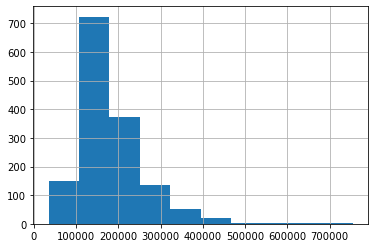

In [49]:
df_train.SalePrice.hist()

<AxesSubplot:>

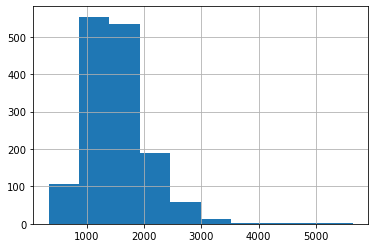

In [53]:
df_train.GrLivArea.hist()

### Drop outlier of sale price

In [50]:
df_combined = df_combined[(df_combined['SalePrice']>4000) | (df_combined['SalePrice'].isna())]

In [52]:
df_combined[df_combined['SalePrice'].isna()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageCars,GarageArea,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,source,BsmtFinSF,Overall,Age,Garage_Age,Exter,Bsmt,BsmtType1,BsmtType2,BsmtOverall,Fireplace,Garage,Porch


In [51]:
main_data_profiling(df_combined)

,column_names,data_type,unique_count,min_value,max_value,mean_value,median_value,null_values,total_rows,%_null_values,num_lower_outliers,num_higher_outliers
0,Id,int64,1460,1.0,1460.0,730.500000,730.5,0,1460,0.0,0.0,0.0
1,MSSubClass,int64,15,20.0,190.0,56.897260,50.0,0,1460,0.0,0.0,103.0
2,MSZoning,object,5,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN
3,LotFrontage,float64,111,0.0,313.0,57.623288,63.0,0,1460,0.0,0.0,16.0
4,LotArea,int64,1073,1300.0,215245.0,10516.828082,9478.5,0,1460,0.0,2.0,67.0
5,Street,object,2,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN
6,Alley,object,3,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN
7,LotShape,object,4,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN
8,LandContour,object,4,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN
9,Utilities,object,2,NaN,NaN,NaN,NaN,0,1460,0.0,NaN,NaN


### Upload transformed data

In [42]:
df_combined.to_sql('transformed_combined', dbConnection, if_exists='replace', index=False)

In [43]:
df_profile.to_sql('raw_data_profile', dbConnection, if_exists='replace', index=False, method='multi')